In [61]:
# set this to the graph type to generate
# can be one of:
# 1. shared_hca
# 2. softroce
# 3. sriov
# 4. freeflow
MODE = "freeflow"

<IPython.core.display.Javascript object>

In [62]:
%load_ext nb_black

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

import pandas as pd

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [63]:
IB_METHODS = ["read", "write", "send"]

if MODE == "softroce":
    DATA_DIR = "softroce_multi_vdev"
    TITLE_DEV_NAME = "SoftRoCE"
    LEGEND_DEV_NAME = "rxe"
elif MODE == "shared_hca":
    DATA_DIR = "shared_hca_multi_dev"
    TITLE_DEV_NAME = "Shared HCA"
    LEGEND_DEV_NAME = "shared"
elif MODE == "sriov":
    DATA_DIR = "sriov_multi_dev"
    TITLE_DEV_NAME = "SRIOV"
    LEGEND_DEV_NAME = "sriov"
elif MODE == "freeflow":
    DATA_DIR = "freeflow_multi_dev"
    TITLE_DEV_NAME = "FreeFlow"
    LEGEND_DEV_NAME = "freeflow"

<IPython.core.display.Javascript object>

In [64]:
dfs = {}

for method in IB_METHODS:
    print(method)
    with open(f"raw/{DATA_DIR}/ib_{method}_bw.txt") as f:
        raw_bw_data = f.read().strip().split("\n")

    raw_bw_data = [r.split("\t") for r in raw_bw_data]
    bw_data = (
        pd.DataFrame(columns=raw_bw_data[0], data=raw_bw_data[1:])
        .set_index("#pairs")
        .astype({"Agg BW average[MB/sec]": "float64", "Agg MsgRate[Mpps]": "float64"})
    )

    with open(f"raw/{DATA_DIR}/{method}_cpu_client.txt") as f:
        raw_cpu_cl_data = f.read().strip().split("\n")

    raw_cpu_cl_data = [r.split("\t") for r in raw_cpu_cl_data]
    cpu_cl_data = (
        pd.DataFrame(columns=raw_cpu_cl_data[0], data=raw_cpu_cl_data[1:])
        .set_index("#pairs")
        .astype({"CPU Usage %": "float64"})
        .rename(columns={"CPU Usage %": "Client CPU Usage %"})
    )

    with open(f"raw/{DATA_DIR}/{method}_cpu_server.txt") as f:
        raw_cpu_serv_data = f.read().strip().split("\n")

    raw_cpu_serv_data = [r.split("\t") for r in raw_cpu_serv_data]
    cpu_serv_data = (
        pd.DataFrame(columns=raw_cpu_serv_data[0], data=raw_cpu_serv_data[1:])
        .set_index("#pairs")
        .astype({"CPU Usage %": "float64"})
        .rename(columns={"CPU Usage %": "Server CPU Usage %"})
    )

    df = pd.concat([bw_data, cpu_cl_data, cpu_serv_data], axis=1)
    print(df.head(), "\n")

    dfs[method] = df

read
        Agg BW average[MB/sec]  Agg MsgRate[Mpps]  \
#pairs                                              
1                      6081.35           0.097302   
2                      6126.40           0.098022   
3                      6126.42           0.098022   
4                      6126.41           0.098023   
5                      6178.61           0.098859   

                            BW averages[MB/sec]  \
#pairs                                            
1                                       6081.35   
2                               3063.22,3063.18   
3                       2042.15,2042.15,2042.12   
4               1531.61,1531.61,1531.60,1531.59   
5       1277.47,1225.29,1225.29,1225.30,1225.26   

                                      MsgRates[Mpps]  Client CPU Usage %  \
#pairs                                                                     
1                                           0.097302              204.16   
2                                  0.

<IPython.core.display.Javascript object>

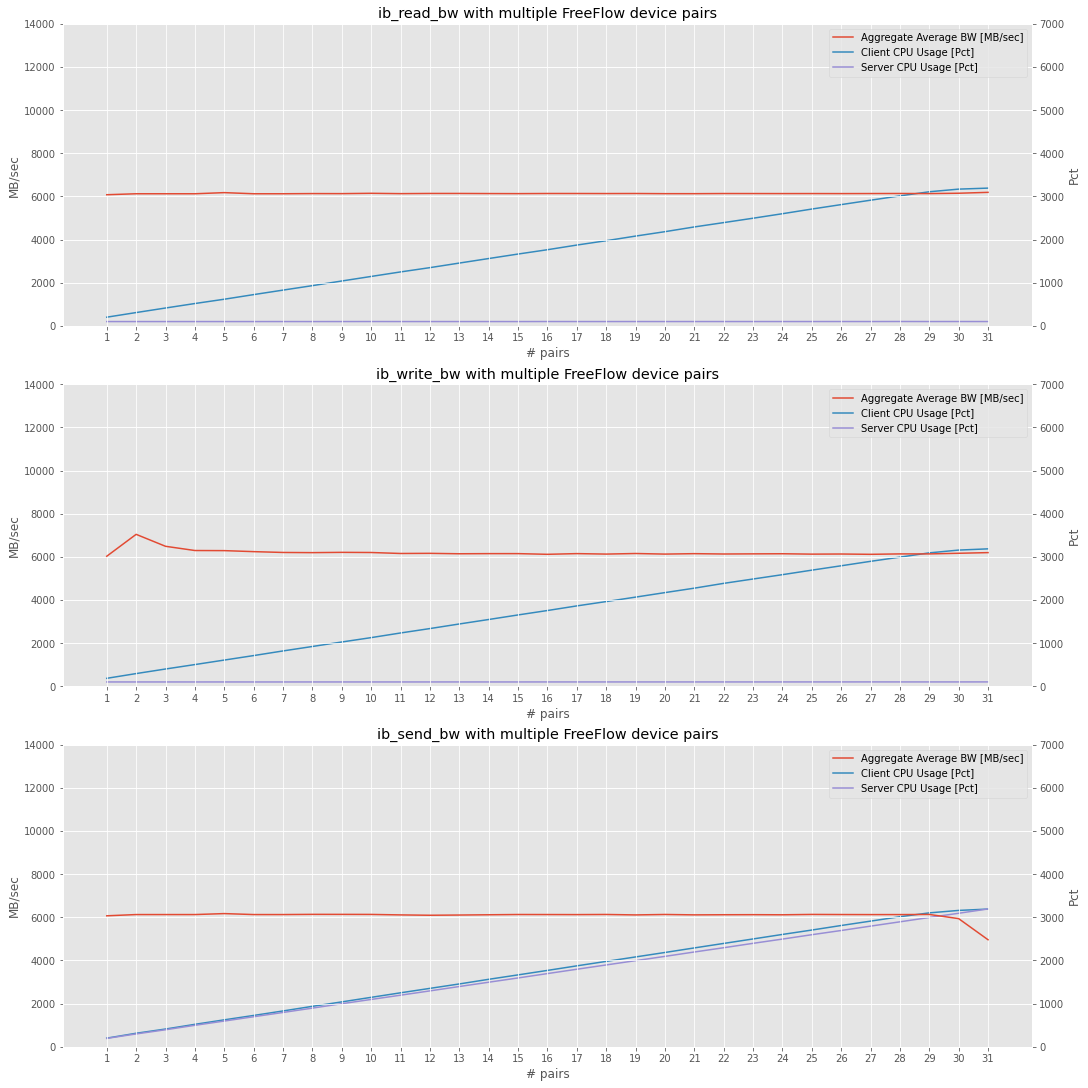

<IPython.core.display.Javascript object>

In [65]:
fig, axs = plt.subplots(len(dfs), 1, layout="constrained")
idx = 0

for method, df in dfs.items():
    ax = axs[idx]

    twin1 = ax.twinx()
    #     twin2 = ax.twinx()
    #     twin2.spines.right.set_position(("axes", 1.2))

    ax.set_zorder(twin1.get_zorder() + 1)
    ax.patch.set_visible(False)
    twin1.patch.set_visible(True)

    (p1,) = ax.plot(
        df.index,
        df["Agg BW average[MB/sec]"],
        color=colors[0],
        label="Aggregate Average BW [MB/sec]",
    )
    (p2,) = twin1.plot(
        df.index,
        df["Client CPU Usage %"],
        color=colors[1],
        label="Client CPU Usage [Pct]",
    )
    (p3,) = twin1.plot(
        df.index,
        df["Server CPU Usage %"],
        color=colors[2],
        label="Server CPU Usage [Pct]",
    )
    #     (p4,) = twin2.plot(
    #         df.index,
    #         df["Agg MsgRate[Mpps]"],
    #         color=colors[3],
    #         label="Aggregate Msg Rate [Mpps]",
    #     )

    ax.set_ylim(0, 14000)
    twin1.set_ylim(0, 7000)
    # twin2.set_ylim(0, 0.5)

    ax.set_xlabel("# pairs")
    ax.set_ylabel("MB/sec")
    twin1.set_ylabel("Pct")
    # twin2.set_ylabel("Mpps")

    ax.legend(handles=[p1, p2, p3])
    ax.set_title(f"ib_{method}_bw with multiple {TITLE_DEV_NAME} device pairs")

    idx += 1

plt.savefig(f"{DATA_DIR}.png")
plt.show()